# Telecom Churn Case Study 

## Objectives 

1. The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

2. It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

3. It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

4. Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

5. Recommend strategies to manage customer churn based on your observations.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,plot_roc_curve
from sklearn.model_selection import cross_validate,GridSearchCV,cross_val_score,RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

#pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)

## EDA on Train Dataset 

In [2]:
# Read the data from csv file
telecom=pd.read_csv('train.csv')
telecom.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [3]:
# Checking the shape of dataframe
telecom.shape

(69999, 172)

There are 69999 are rows and 172 columns

In [4]:
# Checking for duplicate rows
telecom.duplicated().value_counts()

False    69999
dtype: int64

No duplicates are present

In [5]:
# Checking data information
telecom.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [6]:
# Check churn customers
telecom['churn_probability'].value_counts()

0    62867
1     7132
Name: churn_probability, dtype: int64

In [7]:
# Checking for churn rate
print('Churn Rate : {0}%'.format(round(((sum(telecom['churn_probability'])/len(telecom['churn_probability']))*100),2)))

Churn Rate : 10.19%


Churn rate is less than 10% of the overall data available. This indicates that we would need to handle the class imbalance in this classification problem.

In [8]:
# Checking for null values
null=telecom.isnull().sum()*100/telecom.shape[0]
null1=null[null!=0]
null1

loc_og_t2o_mou           1.002871
std_og_t2o_mou           1.002871
loc_ic_t2o_mou           1.002871
last_date_of_month_7     0.570008
last_date_of_month_8     1.047158
                          ...    
night_pck_user_7        74.478207
night_pck_user_8        73.689624
fb_user_6               74.902499
fb_user_7               74.478207
fb_user_8               73.689624
Length: 125, dtype: float64

In [9]:
# Imputing null values for below column by 'NA'
for col in ('total_rech_data_6', 'total_rech_data_7','total_rech_data_8','max_rech_data_6','max_rech_data_7','max_rech_data_8',
'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','av_rech_amt_data_6',
'av_rech_amt_data_7','av_rech_amt_data_8','night_pck_user_6','night_pck_user_7','night_pck_user_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6',
'offnet_mou_7', 'offnet_mou_8','roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','loc_og_t2t_mou_6','loc_og_t2t_mou_7',
'loc_og_t2t_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2c_mou_6',
'loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2m_mou_6',
'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','std_og_t2c_mou_6','std_og_t2c_mou_7',
'std_og_t2c_mou_8','std_og_mou_6','std_og_mou_7','std_og_mou_8','isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','spl_og_mou_6','spl_og_mou_7',
'spl_og_mou_8','og_others_6','og_others_7','og_others_8','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2m_mou_6',
'loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','std_ic_mou_6',
'std_ic_mou_7','std_ic_mou_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8','ic_others_6',
'ic_others_7','ic_others_8','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'):
    telecom[col]=telecom[col].fillna('0').astype('float64')

In [10]:
# Fill null values in date column
for col in ('date_of_last_rech_6','date_of_last_rech_data_6'):
    telecom[col]=telecom[col].fillna('06/30/2014')

In [11]:
# Fill null values in date column
for col in ('date_of_last_rech_7','date_of_last_rech_data_7'):
    telecom[col]=telecom[col].fillna('07/31/2014')
for col in ('date_of_last_rech_8','date_of_last_rech_data_8'):
    telecom[col]=telecom[col].fillna('08/31/2014')


In [12]:
# Fill null values in date column
for col in ('fb_user_6','fb_user_7','fb_user_8'):
    telecom[col]=telecom[col].fillna('-1')

In [13]:
# Fill null values in date column
telecom['last_date_of_month_7']=telecom['last_date_of_month_7'].fillna('7/31/2014')
telecom['last_date_of_month_8']=telecom['last_date_of_month_8'].fillna('8/31/2014')

In [14]:
# Dropping below columns 
telecom = telecom.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou'],axis='columns')

In [15]:
# Checking for null values
null=telecom.isnull().sum()*100/telecom.shape[0]
null1=null[null!=0]
null1

Series([], dtype: float64)

In [16]:
# Checking dataframe info
telecom.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 168 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    last_date_of_month_6      object 
 2    last_date_of_month_7      object 
 3    last_date_of_month_8      object 
 4    arpu_6                    float64
 5    arpu_7                    float64
 6    arpu_8                    float64
 7    onnet_mou_6               float64
 8    onnet_mou_7               float64
 9    onnet_mou_8               float64
 10   offnet_mou_6              float64
 11   offnet_mou_7              float64
 12   offnet_mou_8              float64
 13   roam_ic_mou_6             float64
 14   roam_ic_mou_7             float64
 15   roam_ic_mou_8             float64
 16   roam_og_mou_6             float64
 17   roam_og_mou_7             float64
 18   roam_og_mou_8             float64
 19   loc_og_t2t_mou_6          float64
 20   loc_

## Derived metrics 

In [17]:
# Average Data pack recharged
telecom['avg_rech_data_amt']=((telecom['count_rech_2g_6']+telecom['count_rech_3g_6'])*telecom['av_rech_amt_data_6'] + (telecom['count_rech_2g_7']+telecom['count_rech_3g_7'])*telecom['av_rech_amt_data_7']+(telecom['count_rech_2g_8']+telecom['count_rech_3g_8'])*telecom['av_rech_amt_data_8'])/3

In [18]:
# Average amount recharged
telecom['avg_rech_amt']=(telecom['total_rech_amt_6']+telecom['total_rech_amt_7']+telecom['total_rech_amt_8'])/3

In [19]:
# Finding average amount 
telecom['av_rech']=telecom['avg_rech_data_amt']+telecom['avg_rech_amt']

In [20]:
# Selecting high value customer
#telecom_high=telecom.loc[telecom['av_rech']>telecom['av_rech'].quantile(0.6),:]

In [21]:
# Create a list date columns
col_dates=[]
for col in list(telecom.columns):
    if ('date' in col):
        col_dates.append(col)
    

In [22]:
#Checking for date column
col_dates

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [23]:
# Convert to datetime format
telecom[col_dates] = telecom[col_dates].apply(pd.to_datetime)

## Feature Engineering 

In [24]:
# Deriving no. of days last recharged
telecom['days_last_rech_6']= telecom['last_date_of_month_6']-telecom['date_of_last_rech_6']
telecom['days_last_rech_7']= telecom['last_date_of_month_7']-telecom['date_of_last_rech_7']
telecom['days_last_rech_8']= telecom['last_date_of_month_8']-telecom['date_of_last_rech_8']
telecom['days_last_rech_data_6']= telecom['last_date_of_month_6']-telecom['date_of_last_rech_data_6']
telecom['days_last_rech_data_7']= telecom['last_date_of_month_7']-telecom['date_of_last_rech_data_7']
telecom['days_last_rech_data_8']= telecom['last_date_of_month_8']-telecom['date_of_last_rech_data_8']

In [25]:
# viewing the new column
telecom['days_last_rech_data_8']

0        0 days
1        0 days
2        0 days
3        0 days
4       11 days
          ...  
69994   10 days
69995    0 days
69996    0 days
69997   17 days
69998   23 days
Name: days_last_rech_data_8, Length: 69999, dtype: timedelta64[ns]

In [26]:
# Convert column into str
for col in ('days_last_rech_6','days_last_rech_7','days_last_rech_8','days_last_rech_data_6','days_last_rech_data_7','days_last_rech_data_8'):
    telecom[col]=telecom[col].astype(str)

In [27]:
# Changing only with numbers
for col in ('days_last_rech_6','days_last_rech_7','days_last_rech_8','days_last_rech_data_6','days_last_rech_data_7','days_last_rech_data_8'):
    telecom[col]=telecom[col].apply(lambda x:x.replace(' days','')).astype(int)

In [28]:
# Dropping below columns 
telecom = telecom.drop(col_dates,axis='columns')

In [29]:
#Checking the values
telecom.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,churn_probability,avg_rech_data_amt,avg_rech_amt,av_rech,days_last_rech_6,days_last_rech_7,days_last_rech_8,days_last_rech_data_6,days_last_rech_data_7,days_last_rech_data_8
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0,0.000000,50.666667,50.666667,8,21,7,0,0,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,0,48.333333,65.000000,113.333333,18,21,5,0,23,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0,0.000000,63.333333,63.333333,19,9,7,0,0,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0,0.000000,176.666667,176.666667,15,10,6,0,0,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0,1138.000000,182.666667,1320.666667,5,5,1,5,8,11


<AxesSubplot:xlabel='churn_probability', ylabel='count'>

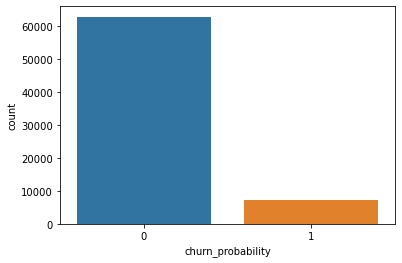

In [30]:
# Plotting churn_probability
sns.countplot(x='churn_probability', data=telecom)

We have more number of non churn customer and less number of churn customer

<AxesSubplot:xlabel='churn_probability', ylabel='aon'>

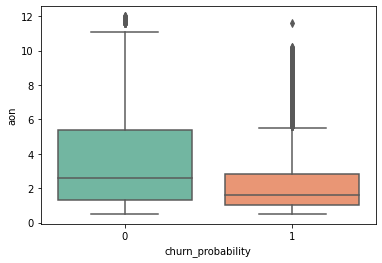

In [31]:
# Convert Age on network to number of years from days
telecom['aon']=round(((telecom['aon']/30)/12),1)
sns.boxplot(y = 'aon', x='churn_probability',palette='Set2', data = telecom)

1. There are more number of observations between 1 and 3 years.
2. churn rate is high during 1 to 2 years.

<AxesSubplot:xlabel='fb_user_8', ylabel='count'>

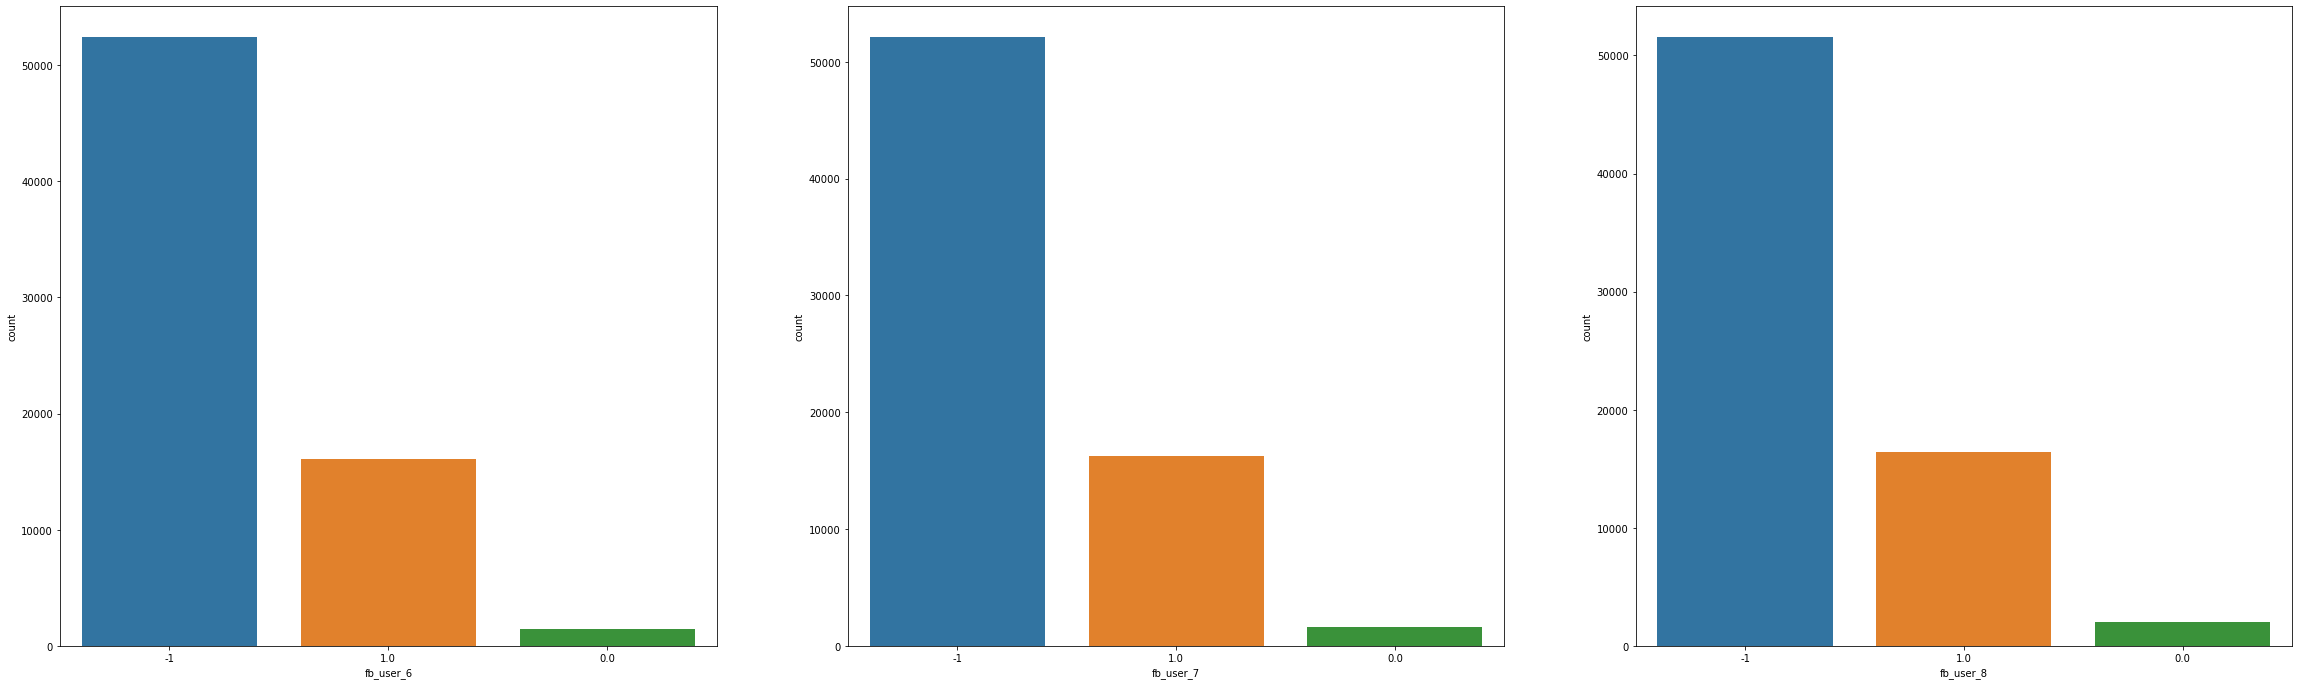

In [32]:
# Checking fb user
plt.subplots(figsize=(40,40))
# Subplot 1
plt.subplot(3,3,1)
sns.countplot(x='fb_user_6' ,data=telecom)
# Subplot 2
plt.subplot(3,3,2)
sns.countplot(x='fb_user_7', data=telecom)
# Subplot 3
plt.subplot(3,3,3)
sns.countplot(x='fb_user_8', data=telecom)

Service scheme for social network is not used moastly(class -1 indicates service usage)
Only Few customers uses the service scheme package

<AxesSubplot:xlabel='av_rech', ylabel='Density'>

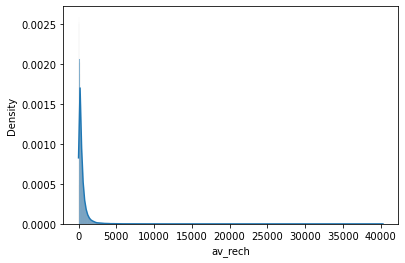

In [33]:
# Plotting histogram for average recharge amount
sns.histplot(telecom['av_rech'],kde=True,stat='density')


Mostly recharge are done with lower amount only

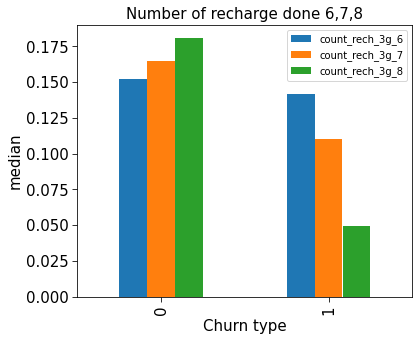

In [34]:
#plot to visualize loc_og_mou
telecom.groupby("churn_probability")['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'].mean().plot.bar(figsize=[6,5])
plt.tick_params(size=5,labelsize = 15) 
plt.title("Number of recharge done 6,7,8",fontsize=15)
plt.ylabel("median",fontsize=15)
plt.xlabel("Churn type",fontsize=15)
plt.show()

1. As number recharge reduces churn probabilty increases
2. As number recharge increases churn probabilty reduces

<AxesSubplot:xlabel='churn_probability', ylabel='roam_og_mou_8'>

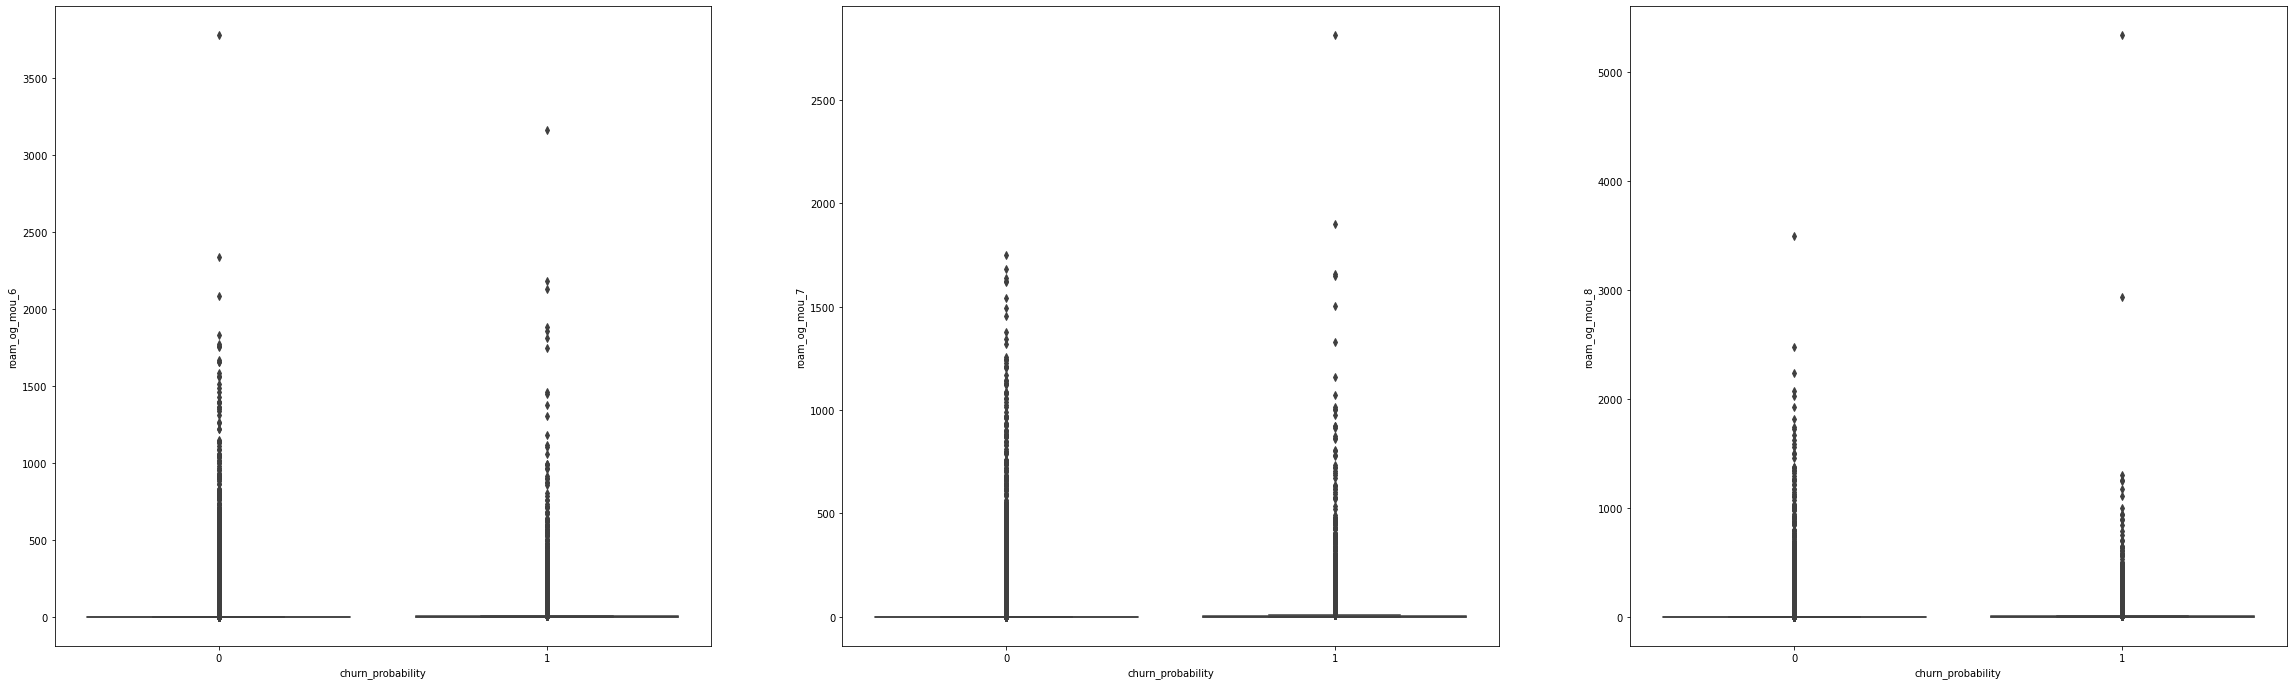

In [35]:
# Max_rech_data features plotting
plt.subplots(figsize=(40,40))
plt.subplot(3,3,1)
sns.boxplot(x='churn_probability', y='roam_og_mou_6', data = telecom)
plt.subplot(3,3,2)
sns.boxplot(x='churn_probability', y='roam_og_mou_7', data = telecom)
plt.subplot(3,3,3)
sns.boxplot(x='churn_probability', y='roam_og_mou_8', data = telecom)

Text(0, 0.5, 'Churn Percentage')

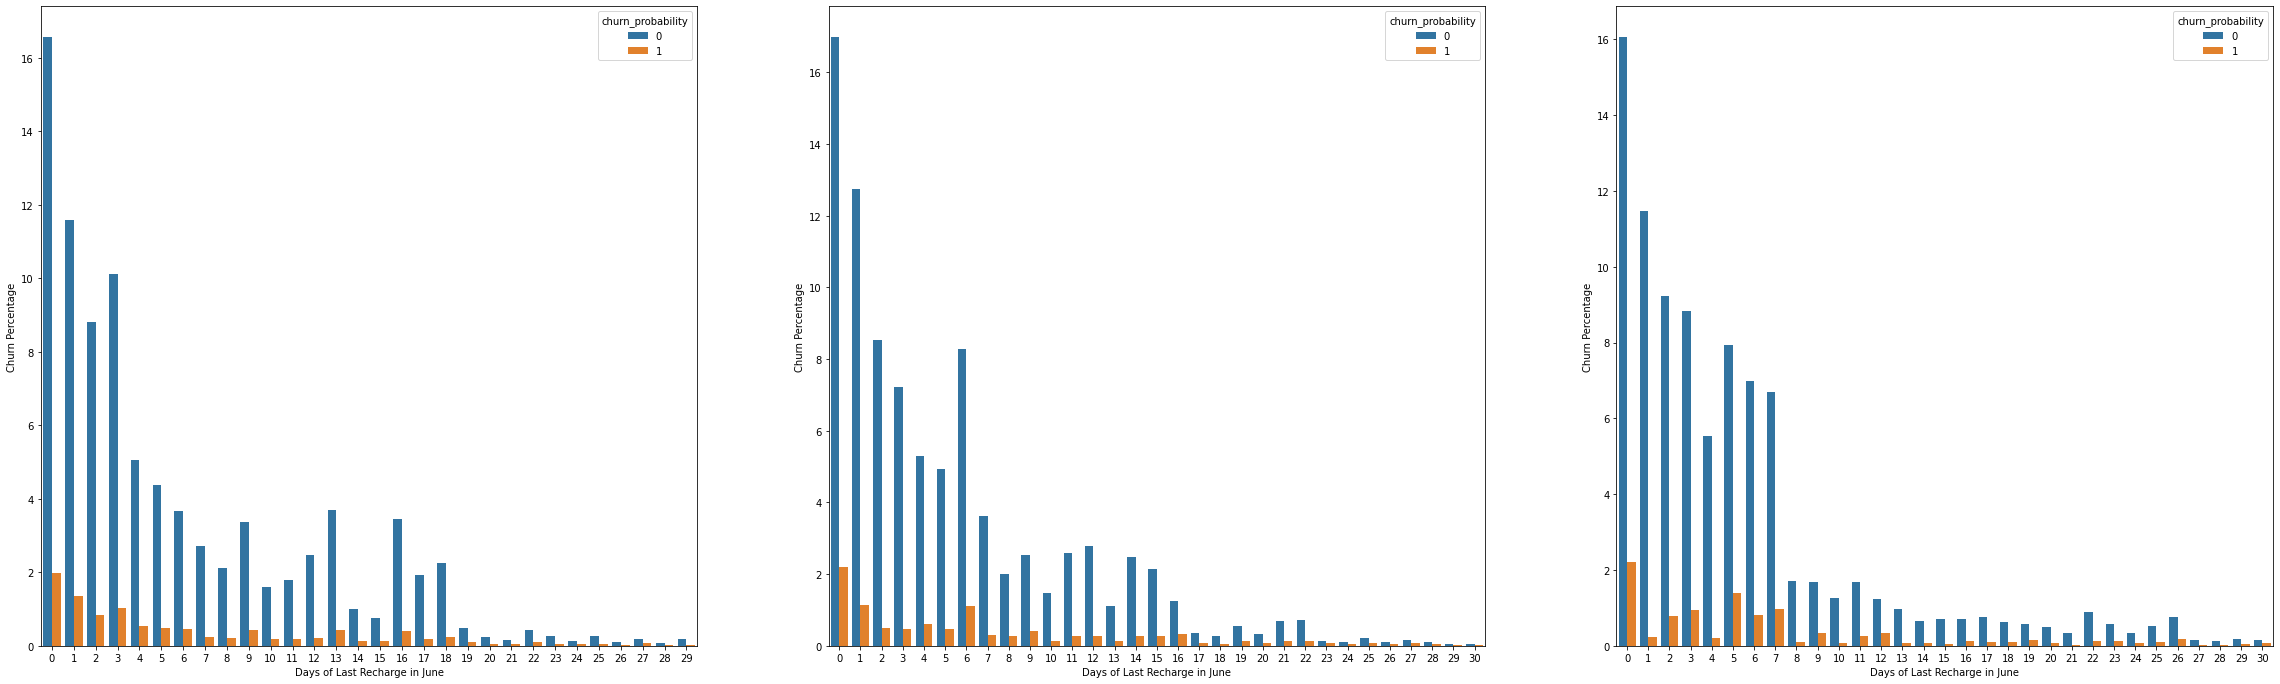

In [36]:
# Plotting against churn_probability with last recharge
plt.subplots(figsize=(40,40))
plt.subplot(3,3,1)
sns.barplot(x="days_last_rech_6", y="churn_probability", hue="churn_probability", data=telecom,estimator=lambda x: len(x) / len(telecom) * 100)
plt.xlabel('Days of Last Recharge in June')
plt.ylabel('Churn Percentage')
plt.subplot(3,3,2)
sns.barplot(x="days_last_rech_7", y="churn_probability", hue="churn_probability", data=telecom,estimator=lambda x: len(x) / len(telecom) * 100)
plt.xlabel('Days of Last Recharge in June')
plt.ylabel('Churn Percentage')
plt.subplot(3,3,3)
sns.barplot(x="days_last_rech_8", y="churn_probability", hue="churn_probability", data=telecom,estimator=lambda x: len(x) / len(telecom) * 100)
plt.xlabel('Days of Last Recharge in June')
plt.ylabel('Churn Percentage')

In [37]:
# Checking percentile values
telecom.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,churn_probability,avg_rech_data_amt,avg_rech_amt,av_rech,days_last_rech_6,days_last_rech_7,days_last_rech_8,days_last_rech_data_6,days_last_rech_data_7,days_last_rech_data_8
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,34999.000000,283.134365,278.185912,278.858826,127.887939,128.754731,125.943607,191.010582,189.585401,186.146273,...,0.101887,165.083366,324.787502,489.870868,5.779511,5.397434,5.362605,2.749196,2.864741,3.024272
std,20207.115084,334.213918,344.366927,351.924315,295.115497,306.326345,304.990552,312.900706,318.492632,318.453812,...,0.302502,703.116317,368.699842,855.954491,6.130029,5.760272,6.086372,6.385352,6.619187,6.818725
min,0.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17499.500000,93.581000,86.714000,84.095000,5.430000,4.910000,4.110000,28.790000,26.690000,23.780000,...,0.000000,0.000000,120.000000,137.333333,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,34999.000000,197.484000,191.588000,192.234000,30.830000,29.160000,27.840000,89.810000,85.590000,83.010000,...,0.000000,0.000000,230.666667,282.333333,3.000000,4.000000,4.000000,0.000000,0.000000,0.000000
75%,52498.500000,370.791000,365.369500,369.909000,113.100000,108.940000,106.280000,223.540000,218.350000,216.410000,...,0.000000,84.000000,414.666667,562.000000,9.000000,8.000000,7.000000,0.000000,0.000000,0.000000
90%,62998.200000,619.993800,615.661400,614.994600,331.766000,334.886000,326.298000,468.898000,470.054000,467.636000,...,1.000000,384.000000,684.000000,1023.666667,16.000000,14.000000,13.000000,13.000000,13.000000,14.000000
95%,66498.100000,832.022700,823.236700,828.464700,598.600000,608.878000,596.125000,719.500000,731.602000,715.915000,...,1.000000,768.766667,908.033333,1496.033333,18.000000,16.000000,20.000000,20.000000,21.000000,21.000000
99%,69298.020000,1400.276640,1414.891380,1445.054800,1429.040400,1461.342200,1448.891000,1520.310000,1517.838600,1492.232400,...,1.000000,2570.333333,1545.000000,3384.673333,25.000000,24.000000,26.000000,27.000000,28.000000,28.000000


In [38]:
# Dropping the outliers using IQR method
num_col = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
def drop_outliers(x):
    
    for col in num_col:
        Q1 = x[col].quantile(.01)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x   

telecom = drop_outliers(telecom)

In [39]:
# Checking for the shape
telecom.shape

(69971, 168)

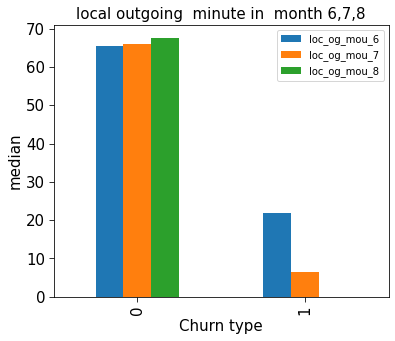

In [40]:
#plot to visualize loc_og_mou
telecom.groupby("churn_probability")["loc_og_mou_6","loc_og_mou_7","loc_og_mou_8"].median().plot.bar(figsize=[6,5])
plt.tick_params(size=5,labelsize = 15) 
plt.title("local outgoing  minute in  month 6,7,8",fontsize=15)
plt.ylabel("median",fontsize=15)
plt.xlabel("Churn type",fontsize=15)
plt.show()

In [41]:
# Creating dummy variable
col=['fb_user_6','fb_user_7','fb_user_8']
telecom_dum = pd.get_dummies(telecom[col],drop_first=True)

In [42]:
# Merging  the dataframe, with the dummy variable dataset.
telecom_final = pd.concat([telecom,telecom_dum],axis=1)

In [43]:
#Droppin fb user
telecom_final = telecom_final.drop(['fb_user_6','fb_user_7','fb_user_8'],axis=1)

In [44]:
# Checking data
telecom_final.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,days_last_rech_8,days_last_rech_data_6,days_last_rech_data_7,days_last_rech_data_8,fb_user_6_1.0,fb_user_6_-1,fb_user_7_1.0,fb_user_7_-1,fb_user_8_1.0,fb_user_8_-1
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,7,0,0,0,0,1,0,1,0,1
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,5,0,23,0,0,1,1,0,0,1
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,7,0,0,0,0,1,0,1,0,1
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,6,0,0,0,0,1,0,1,0,1
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,1,5,8,11,1,0,1,0,1,0


In [45]:
# Selecting high value customer
telecom_highcust=telecom_final.loc[telecom_final['av_rech']>telecom_final['av_rech'].quantile(0.6),:]

In [46]:
# Dropping id variable
telecom_id=telecom_final['id']
y_telecom=telecom_final['churn_probability']

telecom_final=telecom_final.drop(['id','churn_probability'],axis=1)

In [47]:
# Checking info
telecom_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69971 entries, 0 to 69998
Data columns (total 169 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    arpu_6                 float64
 1    arpu_7                 float64
 2    arpu_8                 float64
 3    onnet_mou_6            float64
 4    onnet_mou_7            float64
 5    onnet_mou_8            float64
 6    offnet_mou_6           float64
 7    offnet_mou_7           float64
 8    offnet_mou_8           float64
 9    roam_ic_mou_6          float64
 10   roam_ic_mou_7          float64
 11   roam_ic_mou_8          float64
 12   roam_og_mou_6          float64
 13   roam_og_mou_7          float64
 14   roam_og_mou_8          float64
 15   loc_og_t2t_mou_6       float64
 16   loc_og_t2t_mou_7       float64
 17   loc_og_t2t_mou_8       float64
 18   loc_og_t2m_mou_6       float64
 19   loc_og_t2m_mou_7       float64
 20   loc_og_t2m_mou_8       float64
 21   loc_og_t2f_mou_6       float64
 2

In [48]:
# Scaling the numerical data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric=telecom_final.columns
telecom_final[numeric] = scaler.fit_transform(telecom_final[numeric])

In [49]:
# verifying the values after appying scaling.
telecom_final.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,days_last_rech_8,days_last_rech_data_6,days_last_rech_data_7,days_last_rech_data_8,fb_user_6_1.0,fb_user_6_-1,fb_user_7_1.0,fb_user_7_-1,fb_user_8_1.0,fb_user_8_-1
count,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,...,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04,6.997100e+04
mean,-4.528969e-17,-8.165425e-17,-1.258372e-16,-4.637975e-16,1.906250e-16,4.827672e-16,4.557688e-16,2.862818e-16,3.910684e-16,8.293935e-16,...,-2.983876e-16,2.872100e-16,-2.096843e-16,1.630946e-15,4.033062e-15,-1.071086e-15,1.246459e-15,4.707202e-16,7.655082e-16,3.356713e-15
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-7.619161e+00,-4.562880e+00,-3.490098e+00,-4.338673e-01,-4.208983e-01,-4.130801e-01,-6.119347e-01,-5.974443e-01,-5.860404e-01,-1.666959e-01,...,-8.813156e-01,-4.305912e-01,-4.328341e-01,-4.435367e-01,-5.465064e-01,-1.727557e+00,-5.497914e-01,-1.708335e+00,-5.530530e-01,-1.673716e+00
25%,-5.672057e-01,-5.562308e-01,-5.543014e-01,-4.154124e-01,-4.048682e-01,-3.995812e-01,-5.195534e-01,-5.131703e-01,-5.111048e-01,-1.666959e-01,...,-7.170095e-01,-4.305912e-01,-4.328341e-01,-4.435367e-01,-5.465064e-01,-1.727557e+00,-5.497914e-01,-1.708335e+00,-5.530530e-01,-1.673716e+00
50%,-2.559806e-01,-2.511599e-01,-2.461677e-01,-3.292214e-01,-3.254711e-01,-3.216751e-01,-3.238770e-01,-3.272810e-01,-3.243334e-01,-1.666959e-01,...,-2.240913e-01,-4.305912e-01,-4.328341e-01,-4.435367e-01,-5.465064e-01,5.788520e-01,-5.497914e-01,5.853654e-01,-5.530530e-01,5.974729e-01
75%,2.630807e-01,2.542007e-01,2.599807e-01,-4.967853e-02,-6.447103e-02,-6.430906e-02,1.050319e-01,9.149885e-02,9.604412e-02,-1.666959e-01,...,2.688269e-01,-4.305912e-01,-4.328341e-01,-4.435367e-01,-5.465064e-01,5.788520e-01,-5.497914e-01,5.853654e-01,-5.530530e-01,5.974729e-01
max,8.228757e+01,1.014993e+02,9.482579e+01,2.463734e+01,2.629405e+01,3.490269e+01,2.623053e+01,2.165234e+01,4.359110e+01,5.053097e+01,...,4.047866e+00,4.110337e+00,4.098848e+00,3.955949e+00,1.829805e+00,5.788520e-01,1.818872e+00,5.853654e-01,1.808145e+00,5.974729e-01


In [50]:
# Naming X_train and y_train
X_train = telecom_final
y_train = y_telecom

## EDA for Test Dataset 

In [51]:
# Read the data from csv file
telecom_test=pd.read_csv('test.csv')
telecom_test.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [52]:
# Checking the shape of dataframe
telecom_test.shape

(30000, 171)

There are 30000 are rows and 171 columns in test dataset

In [53]:
# Checking for duplicate rows
telecom_test.duplicated().value_counts()

False    30000
dtype: int64

No duplicates are present

In [54]:
# Checking data information
telecom_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [55]:
# Checking for null values
null2=telecom_test.isnull().sum()*100/telecom_test.shape[0]
null2

id                 0.000000
circle_id          0.000000
loc_og_t2o_mou     1.053333
std_og_t2o_mou     1.053333
loc_ic_t2o_mou     1.053333
                    ...    
fb_user_8         73.593333
aon                0.000000
aug_vbc_3g         0.000000
jul_vbc_3g         0.000000
jun_vbc_3g         0.000000
Length: 171, dtype: float64

In [56]:
# Imputing null values for below column by 'NA'
for col in ('total_rech_data_6', 'total_rech_data_7','total_rech_data_8','max_rech_data_6','max_rech_data_7','max_rech_data_8',
'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','av_rech_amt_data_6',
'av_rech_amt_data_7','av_rech_amt_data_8','night_pck_user_6','night_pck_user_7','night_pck_user_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6',
'offnet_mou_7', 'offnet_mou_8','roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','loc_og_t2t_mou_6','loc_og_t2t_mou_7',
'loc_og_t2t_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2c_mou_6',
'loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2m_mou_6',
'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','std_og_t2c_mou_6','std_og_t2c_mou_7',
'std_og_t2c_mou_8','std_og_mou_6','std_og_mou_7','std_og_mou_8','isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','spl_og_mou_6','spl_og_mou_7',
'spl_og_mou_8','og_others_6','og_others_7','og_others_8','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2m_mou_6',
'loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','std_ic_mou_6',
'std_ic_mou_7','std_ic_mou_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8','ic_others_6',
'ic_others_7','ic_others_8','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'):
    telecom_test[col]=telecom_test[col].fillna('0').astype('float64')

In [57]:
# Filling null values
for col in ('date_of_last_rech_6','date_of_last_rech_data_6'):
    telecom_test[col]=telecom_test[col].fillna('06/30/2014')
for col in ('date_of_last_rech_7','date_of_last_rech_data_7'):
    telecom_test[col]=telecom_test[col].fillna('07/31/2014')
for col in ('date_of_last_rech_8','date_of_last_rech_data_8'):
    telecom_test[col]=telecom_test[col].fillna('08/31/2014')
for col in ('fb_user_6','fb_user_7','fb_user_8'):
    telecom_test[col]=telecom_test[col].fillna('-1')

In [58]:
# Fill null values
telecom_test['last_date_of_month_7']=telecom_test['last_date_of_month_7'].fillna('7/31/2014')
telecom_test['last_date_of_month_8']=telecom_test['last_date_of_month_8'].fillna('8/31/2014')

In [59]:
# Dropping below columns 
telecom_test = telecom_test.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou'],axis='columns')

In [60]:
# checking for null values
null2=telecom_test.isnull().sum()*100/telecom_test.shape[0]
null3=null2[null!=0]
null3

Series([], dtype: float64)

In [61]:
# Total Amount Data
telecom_test['avg_rech_data_amt']=((telecom_test['count_rech_2g_6']+telecom_test['count_rech_3g_6'])*telecom_test['av_rech_amt_data_6'] + (telecom_test['count_rech_2g_7']+telecom_test['count_rech_3g_7'])*telecom_test['av_rech_amt_data_7']+(telecom_test['count_rech_2g_8']+telecom_test['count_rech_3g_8'])*telecom_test['av_rech_amt_data_8'])/3

In [62]:
# creating new feature named av_rech
telecom_test['avg_rech_amt']=(telecom_test['total_rech_amt_6']+telecom_test['total_rech_amt_7']+telecom_test['total_rech_amt_8'])/3

telecom_test['av_rech']=telecom_test['avg_rech_data_amt']+telecom_test['avg_rech_amt']

#telecom_test=telecom_test.loc[telecom_test['av_rech']>telecom_test['av_rech'].quantile(0.6),:]

In [63]:
#checking shape
telecom_test.shape

(30000, 170)

In [64]:
# creating dates into new variable
col_dates=[]
for col in list(telecom_test.columns):
    if ('date' in col):
        col_dates.append(col)

In [65]:
# finding no. of days
telecom_test[col_dates] = telecom_test[col_dates].apply(pd.to_datetime)
telecom_test['days_last_rech_6']= telecom_test['last_date_of_month_6']-telecom_test['date_of_last_rech_6']
telecom_test['days_last_rech_7']= telecom_test['last_date_of_month_7']-telecom_test['date_of_last_rech_7']
telecom_test['days_last_rech_8']= telecom_test['last_date_of_month_8']-telecom_test['date_of_last_rech_8']
telecom_test['days_last_rech_data_6']= telecom_test['last_date_of_month_6']-telecom_test['date_of_last_rech_data_6']
telecom_test['days_last_rech_data_7']= telecom_test['last_date_of_month_7']-telecom_test['date_of_last_rech_data_7']
telecom_test['days_last_rech_data_8']= telecom_test['last_date_of_month_8']-telecom_test['date_of_last_rech_data_8']

In [66]:
# Converting to string datatype
for col in ('days_last_rech_6','days_last_rech_7','days_last_rech_8','days_last_rech_data_6','days_last_rech_data_7','days_last_rech_data_8'):
    telecom_test[col]=telecom_test[col].astype(str)

In [67]:
# Replacing ' days' with ''
for col in ('days_last_rech_6','days_last_rech_7','days_last_rech_8','days_last_rech_data_6','days_last_rech_data_7','days_last_rech_data_8'):
    telecom_test[col]=telecom_test[col].apply(lambda x:x.replace(' days','')).astype(int)

In [68]:
# Dropping below columns 
telecom_test = telecom_test.drop(col_dates,axis='columns')
telecom_test.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,jun_vbc_3g,avg_rech_data_amt,avg_rech_amt,av_rech,days_last_rech_6,days_last_rech_7,days_last_rech_8,days_last_rech_data_6,days_last_rech_data_7,days_last_rech_data_8
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,...,0.00,0.0,84.333333,84.333333,9,5,7,0,0,0
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,...,0.00,0.0,500.000000,500.000000,11,15,7,0,0,0
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,...,241.84,0.0,833.333333,833.333333,1,4,3,0,0,0
3,70002,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,...,0.00,0.0,123.333333,123.333333,5,1,7,0,0,0
4,70003,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,...,0.00,0.0,464.000000,464.000000,1,2,1,0,0,0


In [69]:
# Checking shape
telecom_test.shape

(30000, 167)

In [70]:
# Checking percentile values
telecom_test.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,jun_vbc_3g,avg_rech_data_amt,avg_rech_amt,av_rech,days_last_rech_6,days_last_rech_7,days_last_rech_8,days_last_rech_data_6,days_last_rech_data_7,days_last_rech_data_8
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,84998.500000,282.644348,279.355021,279.845167,125.539490,127.946958,125.679297,188.117924,189.104353,185.668382,...,59.891621,164.671903,325.089944,489.761847,5.839667,5.496300,5.327867,2.765033,2.926167,3.008633
std,8660.398374,314.560212,323.205370,326.437029,286.076687,298.064169,294.988494,312.988297,329.261711,327.934516,...,246.098292,690.206407,343.411201,836.895296,6.147120,5.785191,6.067954,6.412893,6.707007,6.779736
min,69999.000000,-185.043000,-2014.045000,-146.859000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,77498.750000,92.907500,87.504750,84.180500,5.410000,4.790000,4.047500,28.605000,26.580000,24.025000,...,0.000000,0.000000,120.000000,136.666667,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,84998.500000,198.227500,191.775000,191.690500,31.400000,29.410000,28.480000,89.280000,84.925000,83.485000,...,0.000000,0.000000,228.666667,280.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,92498.250000,371.969250,365.250750,367.804750,111.517500,108.845000,108.040000,220.150000,216.930000,213.745000,...,0.000000,84.000000,414.000000,562.000000,9.000000,8.000000,7.000000,0.000000,0.000000,0.000000
90%,96998.100000,620.260800,620.143300,625.653500,328.135000,332.953000,328.650000,453.975000,466.863000,464.801000,...,116.964000,382.000000,685.333333,1025.700000,16.000000,14.000000,13.000000,13.000000,13.000000,14.000000
95%,98498.050000,821.174300,837.930800,842.554150,587.766000,601.692000,592.098000,695.838500,719.329500,701.671000,...,400.499500,776.750000,921.333333,1518.383333,18.000000,17.000000,20.000000,20.000000,21.000000,21.000000
99%,99698.010000,1430.489780,1451.245030,1483.087270,1358.320700,1468.186100,1463.387700,1505.469400,1539.692700,1509.771300,...,1181.646200,2532.356667,1560.006667,3351.013333,24.000000,24.000000,26.000000,27.000000,28.000000,28.000000


In [71]:
telecom_test.shape

(30000, 167)

In [72]:
#Create dummy variables
col=['fb_user_6','fb_user_7','fb_user_8']
telecom_test_dum = pd.get_dummies(telecom_test[col],drop_first=True)


# Merging  the dataframe, with the dummy variable dataset.
telecom_test_final = pd.concat([telecom_test,telecom_test_dum],axis=1)

telecom_test_final = telecom_test_final.drop(['fb_user_6','fb_user_7','fb_user_8'],axis=1)

telecom_test_final.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,days_last_rech_8,days_last_rech_data_6,days_last_rech_data_7,days_last_rech_data_8,fb_user_6_1.0,fb_user_6_-1,fb_user_7_1.0,fb_user_7_-1,fb_user_8_1.0,fb_user_8_-1
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,...,7,0,0,0,0,1,0,1,0,1
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,...,7,0,0,0,0,1,0,1,0,1
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,...,3,0,0,0,0,1,0,1,0,1
3,70002,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,...,7,0,0,0,0,1,0,1,0,1
4,70003,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,...,1,0,0,0,0,1,0,1,0,1


In [73]:
telecom_test_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 170 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    id                     int64  
 1    arpu_6                 float64
 2    arpu_7                 float64
 3    arpu_8                 float64
 4    onnet_mou_6            float64
 5    onnet_mou_7            float64
 6    onnet_mou_8            float64
 7    offnet_mou_6           float64
 8    offnet_mou_7           float64
 9    offnet_mou_8           float64
 10   roam_ic_mou_6          float64
 11   roam_ic_mou_7          float64
 12   roam_ic_mou_8          float64
 13   roam_og_mou_6          float64
 14   roam_og_mou_7          float64
 15   roam_og_mou_8          float64
 16   loc_og_t2t_mou_6       float64
 17   loc_og_t2t_mou_7       float64
 18   loc_og_t2t_mou_8       float64
 19   loc_og_t2m_mou_6       float64
 20   loc_og_t2m_mou_7       float64
 21   loc_og_t2m_mou_8       float64
 2

In [74]:
# Drop id from test data
telecom_test_id=telecom_test_final['id']
telecom_test_final=telecom_test_final.drop('id',axis=1)

In [75]:
# Scaling the numerical data
scaler = StandardScaler()
numeric=telecom_test_final.columns
telecom_test_final[numeric] = scaler.fit_transform(telecom_test_final[numeric])

In [76]:
# verifying the values after appying scaling.
telecom_test_final.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,days_last_rech_8,days_last_rech_data_6,days_last_rech_data_7,days_last_rech_data_8,fb_user_6_1.0,fb_user_6_-1,fb_user_7_1.0,fb_user_7_-1,fb_user_8_1.0,fb_user_8_-1
count,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,...,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04
mean,-1.684731e-16,-9.390636e-19,2.223407e-17,-2.441695e-16,8.555379e-17,-9.393782e-17,7.153722e-17,1.989677e-16,2.255233e-17,5.976553e-16,...,1.059255e-16,1.142178e-15,-1.711668e-16,-9.622303e-16,2.892205e-16,1.533581e-15,-3.200995e-16,-2.496670e-16,1.098780e-15,1.325932e-15
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,...,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.486822e+00,-7.095916e+00,-1.307178e+00,-4.388389e-01,-4.292669e-01,-4.260552e-01,-6.010482e-01,-5.743380e-01,-5.661846e-01,-1.017693e-01,...,-8.780481e-01,-4.311751e-01,-4.362923e-01,-4.437759e-01,-5.466386e-01,-1.719062e+00,-5.511119e-01,-1.700903e+00,-5.550689e-01,-1.669408e+00
25%,-6.031914e-01,-5.935962e-01,-5.994048e-01,-4.199276e-01,-4.131963e-01,-4.123341e-01,-5.096535e-01,-4.936106e-01,-4.929218e-01,-1.017693e-01,...,-7.132452e-01,-4.311751e-01,-4.362923e-01,-4.437759e-01,-5.466386e-01,-1.719062e+00,-5.511119e-01,-1.700903e+00,-5.550689e-01,-1.669408e+00
50%,-2.683691e-01,-2.709778e-01,-2.700556e-01,-3.290763e-01,-3.305953e-01,-3.295075e-01,-3.157932e-01,-3.164082e-01,-3.116021e-01,-1.017693e-01,...,-3.836393e-01,-4.311751e-01,-4.362923e-01,-4.437759e-01,-5.466386e-01,5.817125e-01,-5.511119e-01,5.879231e-01,-5.550689e-01,5.990148e-01
75%,2.839723e-01,2.657665e-01,2.694579e-01,-4.901561e-02,-6.408780e-02,-5.979756e-02,1.023444e-01,8.451062e-02,8.561796e-02,-1.017693e-01,...,2.755725e-01,-4.311751e-01,-4.362923e-01,-4.437759e-01,-5.466386e-01,5.817125e-01,-5.511119e-01,5.879231e-01,-5.550689e-01,5.990148e-01
max,3.392864e+01,4.005187e+01,4.051737e+01,2.383604e+01,2.443495e+01,2.236772e+01,2.164444e+01,2.878617e+01,4.074714e+01,1.399071e+02,...,4.066040e+00,4.091040e+00,4.036716e+00,3.981249e+00,1.829362e+00,5.817125e-01,1.814514e+00,5.879231e-01,1.801578e+00,5.990148e-01


In [77]:
# Copy to X_test
X_test=telecom_test_final

## PCA

In [78]:
# Initialize PCA
pca = PCA(random_state=100)
pca.fit(X_train)

PCA(random_state=100)

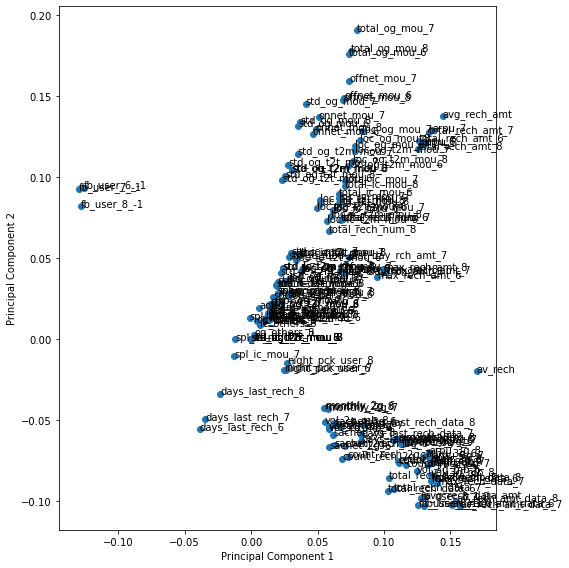

In [79]:
# Plot figure for pca components
fig = plt.figure(figsize = (8,8))
plt.scatter(pca.components_[0],pca.components_[1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(telecom_final.columns):
    plt.annotate(txt, (pca.components_[0][i],pca.components_[1][i]))
plt.tight_layout()
plt.show()


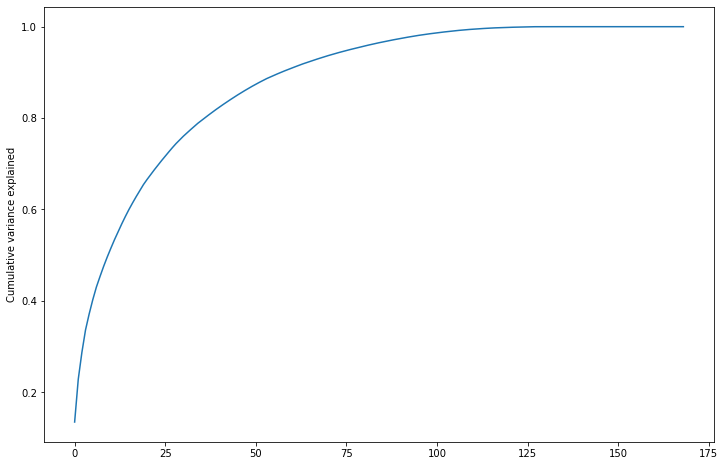

In [80]:
# Plotting explained_variance_ratio_
fig = plt.figure(figsize=[12,8])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel("Cumulative variance explained")
plt.show()

In [81]:
# By providing variance value we can also get the suitable principal components.
pca_demo = PCA(0.95,random_state=40)
X_train_pca1 = pca_demo.fit_transform(X_train)
print(f"suitable principal components for 95% of variance:{X_train_pca1.shape[1]}")

suitable principal components for 95% of variance:78


In [82]:
# Initialize PCA
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=78)

In [83]:
# Fit and transform 
X_train_pca = pca_final.fit_transform(X_train)

In [84]:
# Finding correlation coefficient
corrmat = np.corrcoef(X_train_pca.transpose())

In [85]:
# Finding the shape 
corrmat.shape

(78, 78)

<AxesSubplot:>

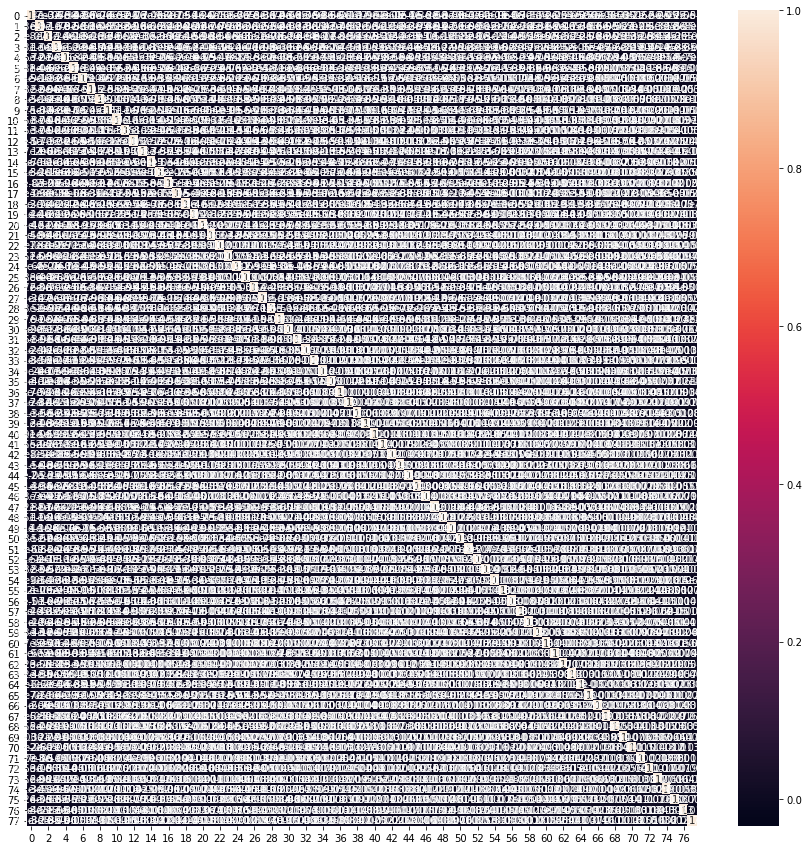

In [86]:
# Plotting heatmap
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

In [87]:
# Transform pca for test dataset
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(30000, 78)

## Logistic Regression with PCA

In [88]:
# SMOTE algorithm for class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_lr, y_lr = sm.fit_resample(X_train_pca, y_train)

np.bincount(y_lr)

array([62845, 62845], dtype=int64)

In [89]:
# Building model using Logistic regression
lr_pca = LogisticRegression(random_state=42)
log_pca = LogisticRegression(random_state=42)

In [90]:
# Fit the model
log_pca = log_pca.fit(X_lr,y_lr)

In [91]:
# Predicting y train data
y_train_pred = log_pca.predict(X_lr)

In [92]:
# Finding f1 score using cross validation
cv_score = cross_val_score(lr_pca, X_lr,y_lr, cv=5, scoring='f1')
print(f"Cross validation score: {cv_score}")
print('Mean f1 score : ',round(np.mean(cv_score),2))

Cross validation score: [0.83448647 0.84555323 0.84473614 0.84665573 0.84439037]
Mean f1 score :  0.84


In [93]:
# Finding classificatio report
print(classification_report(y_lr, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83     62845
           1       0.81      0.88      0.84     62845

    accuracy                           0.84    125690
   macro avg       0.84      0.84      0.84    125690
weighted avg       0.84      0.84      0.84    125690



In [94]:
# Defining function for drawing ROC curve
from sklearn.metrics import roc_curve, auc
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(9,6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

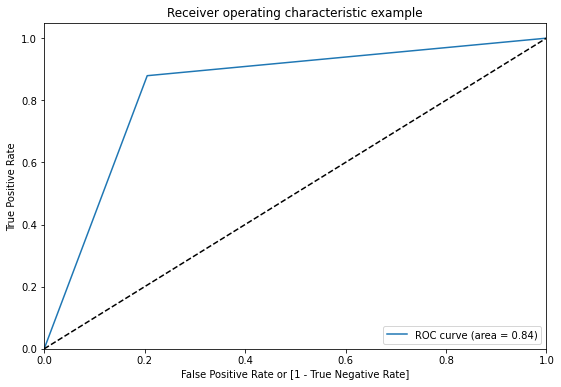

In [95]:
# Plotting ROC curve using user defined function
draw_roc(y_lr, y_train_pred)

Area under curve is 0.84

## Random Forest 

In [96]:
# SMOTE algorithm for class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_rf, y_rf = sm.fit_resample(X_train_pca, y_train)

np.bincount(y_rf)

array([62845, 62845], dtype=int64)

In [97]:
# Building model
rf = RandomForestClassifier(random_state=42, n_estimators=30, max_depth=3)
rf.fit(X_lr, y_lr)

RandomForestClassifier(max_depth=3, n_estimators=30, random_state=42)

In [98]:
# function to find the evaluation model
def evaluate_model(dt_classifier):
    print("Train Accuracy :", f1_score(y_lr, dt_classifier.predict(X_lr)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_lr, dt_classifier.predict(X_lr)))
    print(classification_report(y_lr, dt_classifier.predict(X_lr)))
    print("-"*50)
evaluate_model(rf)

Train Accuracy : 0.7993461700896279
Train Confusion Matrix:
[[48931 13914]
 [11742 51103]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     62845
           1       0.79      0.81      0.80     62845

    accuracy                           0.80    125690
   macro avg       0.80      0.80      0.80    125690
weighted avg       0.80      0.80      0.80    125690

--------------------------------------------------


In [99]:
# Assign Random forest classifier
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [100]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [7,8,10,12],
    'min_samples_leaf': [10, 20, 50],
    'max_features': [2,3,4],
    'n_estimators': [20,30, 50, 100]
}

In [101]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [102]:
# fitting the model
grid_search.fit(X_lr,y_lr)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [7, 8, 10, 12], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [10, 20, 50],
                         'n_estimators': [20, 30, 50, 100]},
             scoring='f1', verbose=1)

In [103]:
# Getting best estimator
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=12, max_features=4, min_samples_leaf=10,
                       n_jobs=-1, random_state=42)

In [104]:
# Evaluating the model performance
evaluate_model(rf_best)

Train Accuracy : 0.9081296789448463
Train Confusion Matrix:
[[56193  6652]
 [ 5043 57802]]
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     62845
           1       0.90      0.92      0.91     62845

    accuracy                           0.91    125690
   macro avg       0.91      0.91      0.91    125690
weighted avg       0.91      0.91      0.91    125690

--------------------------------------------------


In [105]:
# Predicting the y variable for test dataset
y_test = grid_search.predict(X_test_pca)

In [106]:
# converting into dataframe
y_test = pd.Series(y_test)

In [107]:
# merging id and y_test value
sample_test = pd.concat([telecom_test['id'], y_test], axis=1)
sample_test.columns = ['id','churn_probability']
sample_test.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [108]:
# Saving the data into csv file
sample_test.to_csv('sample_rf.csv', index = False)

### Gradient Boosting

In [109]:
# SMOTE algorithm for class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_gb, y_gb = sm.fit_resample(X_train_pca, y_train)

In [110]:
# Finding total count
np.bincount(y_gb)

array([62845, 62845], dtype=int64)

In [111]:
# import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Split data into train and test sets as well as for validation and testing
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_gb,y_gb, train_size= 0.75,random_state=0);
gb = GradientBoostingClassifier(random_state=100)

In [112]:
# Fit the model to our train and target
gb.fit(X_train_gb, y_train_gb)
# Get our predictions
gb_predictions = gb.predict(X_test_gb)

In [113]:
# Finding f1 score and classification report
print(classification_report(y_test_gb, gb_predictions))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     15636
           1       0.85      0.87      0.86     15787

    accuracy                           0.85     31423
   macro avg       0.85      0.85      0.85     31423
weighted avg       0.85      0.85      0.85     31423



In [114]:
# Predicting the y variable for test dataset
y_test = gb.predict(X_test_pca)

In [115]:
# converting into dataframe
y_test = pd.Series(y_test)

In [116]:
# merging id and y_test value
sample_test = pd.concat([telecom_test['id'], y_test], axis=1)
sample_test.columns = ['id','churn_probability']
sample_test.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [117]:
# Saving the data into csv file
sample_test.to_csv('sample_gb.csv', index = False)

## Logistic Regression for high value customer to find important features

In [118]:
# Dataframe with high value customer
telecom_highcust.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,days_last_rech_8,days_last_rech_data_6,days_last_rech_data_7,days_last_rech_data_8,fb_user_6_1.0,fb_user_6_-1,fb_user_7_1.0,fb_user_7_-1,fb_user_8_1.0,fb_user_8_-1
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,1,5,8,11,1,0,1,0,1,0
7,7,167.861,167.869,167.866,0.00,0.00,0.00,0.00,0.00,0.00,...,3,10,9,11,1,0,1,0,1,0
12,12,439.919,397.946,392.024,244.46,108.31,42.98,571.98,727.91,644.43,...,1,0,0,0,0,1,0,1,0,1
15,15,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,...,1,14,0,29,1,0,0,1,1,0
23,23,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,386.91,...,9,0,0,0,0,1,0,1,0,1


In [119]:
# Dropping id variable
y_high=telecom_highcust['churn_probability']

telecom_highcust=telecom_highcust.drop(['churn_probability'],axis=1)

In [120]:
# Scaling the numerical data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric=telecom_highcust.columns
telecom_highcust[numeric] = scaler.fit_transform(telecom_highcust[numeric])

In [121]:
# Naming X_train and y_train
X_train_high = telecom_highcust
y_train_high = y_high

In [122]:
# Building model using Logistic Regressiom
lr = LogisticRegression(class_weight='balanced', random_state=42)
rfe = RFE(lr, n_features_to_select=15)   
rfe = rfe.fit(X_train_high, y_train_high)

In [123]:
# Finding the important features
rfe_features = list(X_train_high.columns[rfe.support_])
print("15 most important features selected by RFE ", rfe_features)

15 most important features selected by RFE  ['offnet_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'og_others_8', 'total_og_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_8', 'spl_ic_mou_8', 'aon', 'days_last_rech_8', 'fb_user_8_1.0']


In [124]:
#List of variables selected in top 15 list
list(zip(X_train_high.columns,rfe.support_,rfe.ranking_))

[('id', False, 115),
 ('arpu_6', False, 21),
 ('arpu_7', False, 35),
 ('arpu_8', False, 9),
 ('onnet_mou_6', False, 71),
 ('onnet_mou_7', False, 117),
 ('onnet_mou_8', False, 57),
 ('offnet_mou_6', False, 98),
 ('offnet_mou_7', False, 70),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 64),
 ('roam_ic_mou_7', False, 18),
 ('roam_ic_mou_8', False, 139),
 ('roam_og_mou_6', False, 110),
 ('roam_og_mou_7', False, 69),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 72),
 ('loc_og_t2t_mou_7', False, 114),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', False, 28),
 ('loc_og_t2m_mou_7', False, 73),
 ('loc_og_t2m_mou_8', False, 126),
 ('loc_og_t2f_mou_6', False, 99),
 ('loc_og_t2f_mou_7', False, 108),
 ('loc_og_t2f_mou_8', False, 87),
 ('loc_og_t2c_mou_6', False, 94),
 ('loc_og_t2c_mou_7', False, 93),
 ('loc_og_t2c_mou_8', False, 60),
 ('loc_og_mou_6', False, 137),
 ('loc_og_mou_7', False, 92),
 ('loc_og_mou_8', False, 58),
 ('std_og_t2t_mou_6', False, 66),
 ('std_og_t2

In [125]:
# Creating X_train dataframe with RFE selected variables
X_train_rfe = X_train_high[rfe_features]
X_train_rfe


,offnet_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,og_others_8,total_og_mou_7,loc_ic_t2t_mou_8,loc_ic_mou_8,total_ic_mou_6,total_ic_mou_8,spl_ic_mou_8,aon,days_last_rech_8,fb_user_8_1.0
4,-0.708952,-0.180414,-0.311422,-0.388079,-0.411036,-0.018922,-0.797928,-0.366816,-0.638683,-0.711811,-0.710583,-0.259346,-0.598660,-0.609249,1.08087
7,-0.730702,-0.180414,-0.339666,-0.388079,-0.411036,-0.018922,-0.864202,-0.205097,-0.594498,-0.701399,-0.665246,-0.259346,-0.673675,-0.212874,1.08087
12,0.724782,-0.180414,-0.321328,-0.285323,1.140142,-0.018922,0.426448,-0.376852,-0.651511,-0.674042,-0.714439,-0.259346,-0.936229,-0.609249,-0.92518
15,-0.285563,-0.180414,0.556170,-0.388079,-0.411036,-0.018922,-0.298093,1.720660,1.403035,-0.094555,1.046906,-0.259346,-0.636168,-0.609249,1.08087
23,0.143157,-0.180414,-0.335565,-0.388079,-0.411036,-0.018922,0.405766,-0.192865,-0.046221,0.971030,-0.199429,-0.259346,-0.786198,0.976248,-0.92518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69990,1.039241,-0.180414,-0.264057,-0.388079,1.491104,-0.018922,0.410366,-0.282004,-0.428786,-0.696586,-0.369619,-0.259346,-0.973737,-0.609249,1.08087
69993,-0.523954,0.865842,-0.339666,-0.388079,-0.411036,-0.018922,-0.351078,-0.383502,-0.726681,-0.665613,-0.771227,-0.259346,0.301525,-0.411062,-0.92518
69994,0.131255,-0.180414,-0.306538,-0.378249,0.347686,-0.018922,-0.097619,-0.171223,0.139988,-0.774633,-0.005840,-0.259346,-1.048752,-0.807436,1.08087
69996,-0.134804,-0.180414,0.021747,-0.388079,-0.411036,-0.018922,-0.406749,0.159303,0.663458,0.806654,0.417677,-0.259346,-0.373614,-0.411062,-0.92518


In [126]:
# Importing libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Checking VIF for multicollinearity
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,loc_ic_mou_8,7.32
10,total_ic_mou_8,6.22
0,offnet_mou_8,5.94
4,std_og_t2m_mou_8,5.15
6,total_og_mou_7,2.42
7,loc_ic_t2t_mou_8,2.17
9,total_ic_mou_6,2.08
3,std_og_t2t_mou_8,1.58
2,loc_og_t2t_mou_8,1.29
14,fb_user_8_1.0,1.13


In [127]:
# Dropping loc_ic_mou_8 as we have high correlation
X_train_rfe = X_train_rfe.drop(["loc_ic_mou_8"], axis = 1)

In [128]:
# Building model using Logistic Regressiom
lr = LogisticRegression(class_weight='balanced', random_state=42)
rfe = RFE(lr, n_features_to_select=15)
rfe = rfe.fit(X_train_rfe, y_train_high)

In [129]:
# Importing libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Checking VIF for multicollinearity
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,offnet_mou_8,5.61
4,std_og_t2m_mou_8,4.78
9,total_ic_mou_8,2.87
6,total_og_mou_7,2.42
8,total_ic_mou_6,2.07
7,loc_ic_t2t_mou_8,1.73
3,std_og_t2t_mou_8,1.57
2,loc_og_t2t_mou_8,1.29
13,fb_user_8_1.0,1.13
11,aon,1.09


In [130]:
# Dropping offnet_mou_8 as we have high correlation
X_train_rfe = X_train_rfe.drop(["offnet_mou_8"], axis = 1)

In [131]:
# Building model using Logistic Regressiom
lr = LogisticRegression(class_weight='balanced', random_state=42)
#rfe = RFE(lr, n_features_to_select=15)
rfe = lr.fit(X_train_rfe, y_train_high)

In [132]:
# Checking VIF for multicollinearity
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,total_ic_mou_8,2.59
5,total_og_mou_7,2.19
7,total_ic_mou_6,2.07
6,loc_ic_t2t_mou_8,1.69
2,std_og_t2t_mou_8,1.49
3,std_og_t2m_mou_8,1.44
1,loc_og_t2t_mou_8,1.29
12,fb_user_8_1.0,1.13
10,aon,1.07
11,days_last_rech_8,1.06


## Better Model  

1. Logistic Regression : Accuracy=0.80, Precision=0.79, Recall=0.81, f1_score=0.80
2. Gradient Boosting   : Accuracy=0.85, Precision=0.85, Recall=0.87, f1_score=0.86
3. Random Forest       : Accuracy=0.90, Precision=0.90, Recall=0.92, f1_score=0.91


By comparing with above three models, we finally decide the best model for this problem is       
" Random Forest " as all metric values are higher.

## Top 10 High customer predicting churn variable 

1. og_others_8 - Outgoing calls in month_8
2. roam_og_mou_8 - outgoing roaming calls minutes of usage in month_8
3. spl_ic_mou_8 - special incoming call on month_8
4. days_last_rech_8 - Last recharge day on month_8
5. aon - Age on network  number of days the customer is using the operator T network
6. fb_user_8_1.0 - Using services of Facebook and similar social networking sites on month_8
7. loc_og_t2t_mou_8 - Local call outgoing within same network in month_8
8. std_og_t2m_mou_8 - standard outgoing call to other network in month_8
9. loc_ic_t2t_mou_8 - Local call incoming within same network in month_8
10. total_ic_mou_6 - total incoming call on month_6

## Conclusion 

Providing discounts or offers to local incoming and outgoing calls will decrease customers from churning.  